In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### set default figsize
plt.rcParams['figure.figsize'] = (14,6)

In [ ]:
mobile_sales = pd.read_excel('mobilesales.xlsx', engine='openpyxl')
mobile_sales.head()

,DATE,Sales
0,2001-01-01,6519.0
1,2001-02-01,6654.0
2,2001-03-01,7332.0
3,2001-04-01,7332.0
4,2001-05-01,8240.0


In [3]:
mobile_sales.set_index('DATE', inplace=True)

In [4]:
mobile_sales.Sales = mobile_sales.Sales.interpolate(method='linear')

<Axes: xlabel='DATE'>

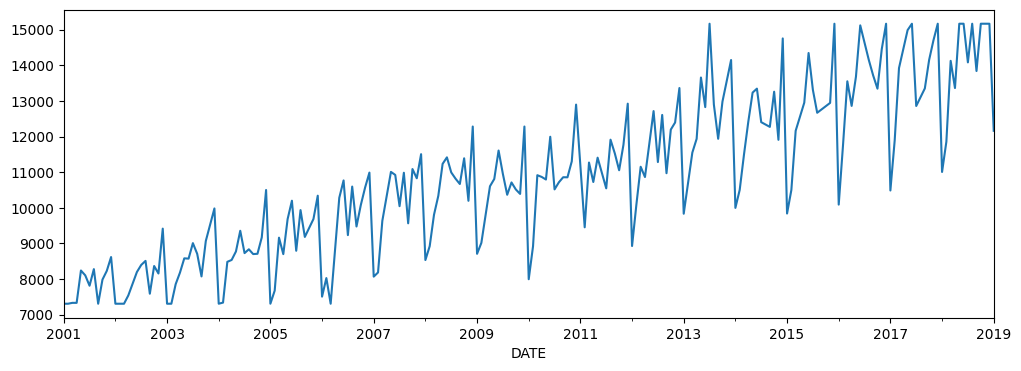

In [5]:
mobile_sales.Sales.clip(lower=mobile_sales.Sales.quantile(0.05), upper=mobile_sales.Sales.quantile(0.95)).plot(figsize=(12,4))

In [6]:
train_max_date = mobile_sales.index[-12]
train_max_date

Timestamp('2018-02-01 00:00:00')

In [7]:
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

In [8]:
import statsmodels.api as sm

def adf_test(dataset):
   pvalue = sm.tsa.stattools.adfuller(dataset)[1]
   print(pvalue)
   if pvalue <= 0.05:
      print('Sequence is stationary')
   else:
      print('Sequence is not stationary')

adf_test(mobile_sales.Sales)

0.9451861677902987
Sequence is not stationary


In [9]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)


### Creating function to measure and print all three metric
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

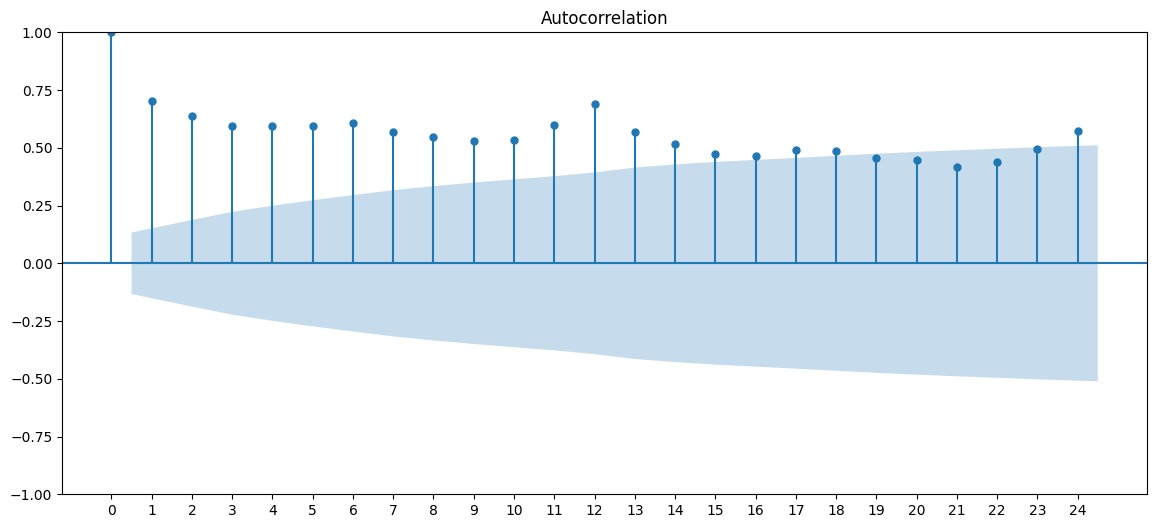

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## ACF
plot_acf(mobile_sales.Sales);
plt.xticks(range(25))
plt.show()

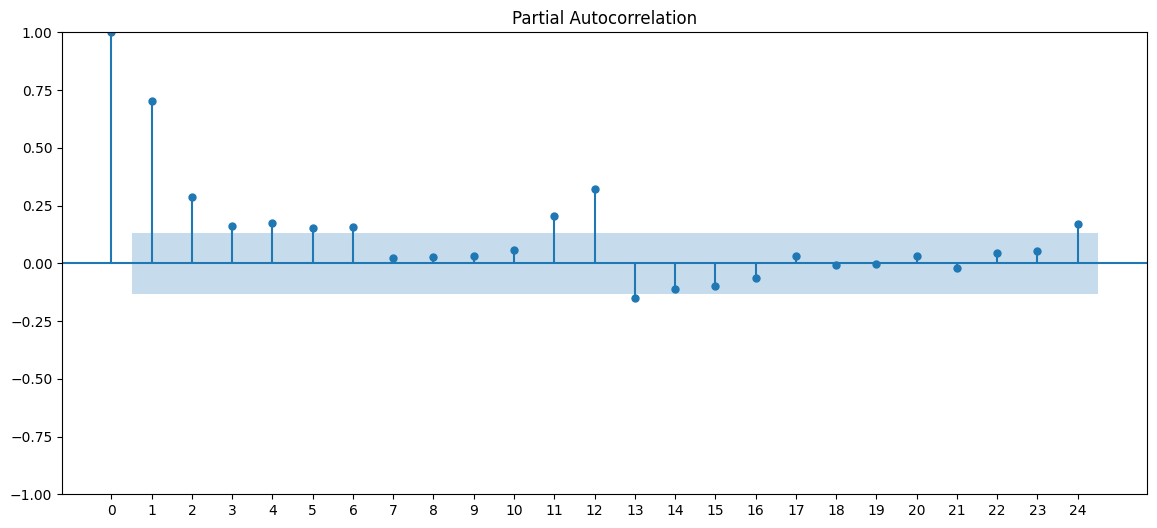

In [12]:
plot_pacf(mobile_sales.Sales);
plt.xticks(range(25))
plt.show()

## ARIMA FAMILY

### AR(p)
- p value is number of previous values to be considered

In [13]:
train_x_st = train_x.copy()
adf_test(train_x_st.Sales)

0.9045467248076599
Sequence is not stationary


In [14]:
train_x_st.Sales = train_x_st.Sales.diff(1).dropna()
train_x_st.dropna(inplace=True)
adf_test(train_x_st.Sales)

4.884740994708033e-21
Sequence is stationary


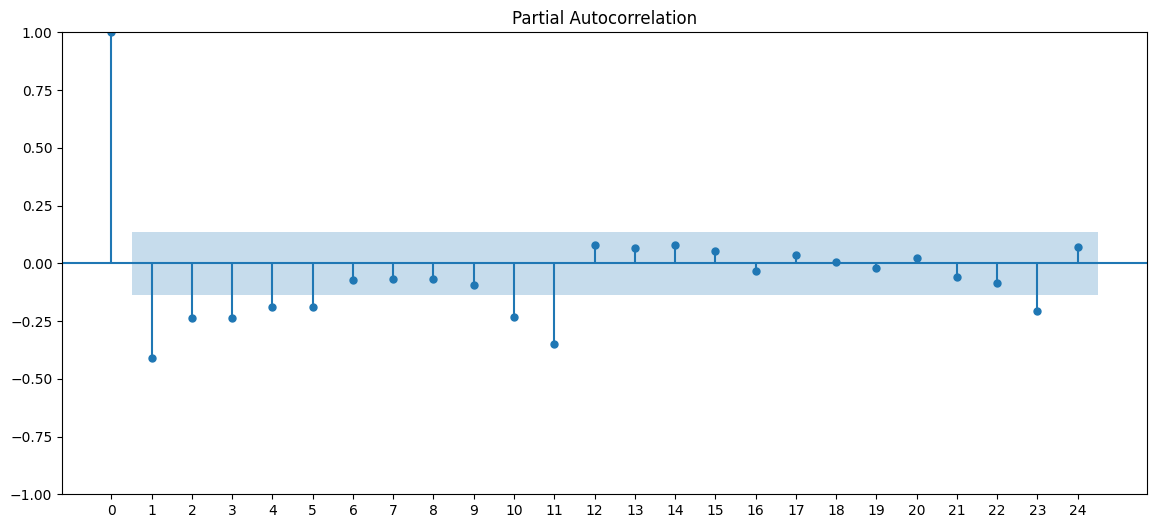

In [15]:
plot_pacf(train_x_st.Sales);
plt.xticks(range(25))
plt.show()

from pacf plot till 6 values, data is above the significance level

so now AR(p), p value will be 6

In [16]:
import statsmodels as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [17]:
p = 1

model = SARIMAX(train_x_st.Sales, order=(p, 0, 0))
model = model.fit()

test_x['pred'] = model.forecast(steps=len(test_x))

test_x['pred']

c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


DATE
2018-02-01    1966.361313
2018-03-01    -822.850993
2018-04-01     344.333339
2018-05-01    -144.091031
2018-06-01      60.296878
2018-07-01     -25.232060
2018-08-01      10.558703
2018-09-01      -4.418435
2018-10-01       1.848955
2018-11-01      -0.773721
2018-12-01       0.323774
2019-01-01      -0.135488
Name: pred, dtype: float64

<Axes: xlabel='DATE'>

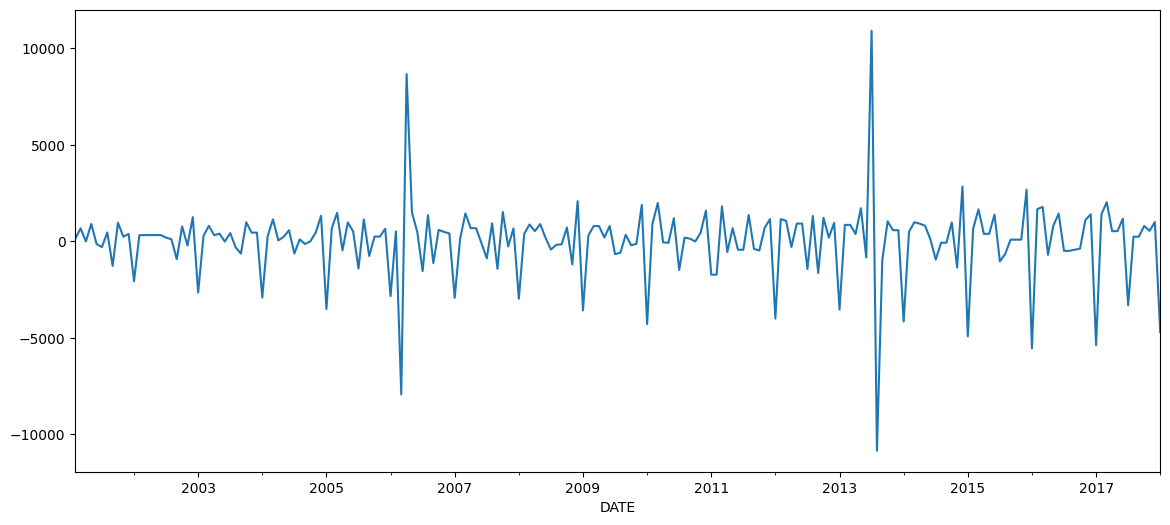

In [18]:
train_x_st.Sales.plot()

<Axes: xlabel='DATE'>

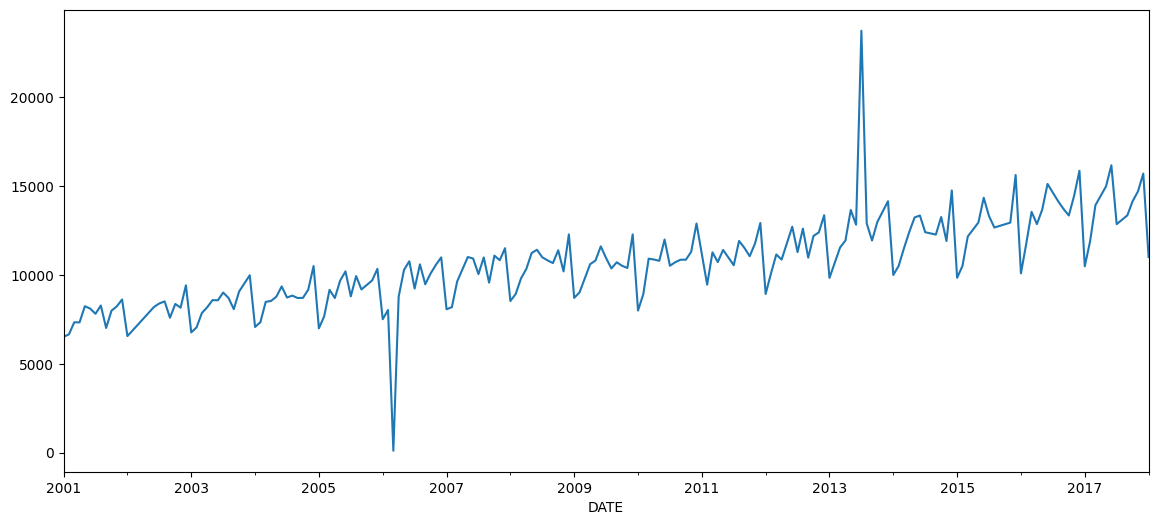

In [19]:
train_x.Sales.plot()

**Inverse of Detrending**

In [20]:
train_x.Sales[-1] + test_x['pred'].cumsum()

C:\Users\FPK1COB\AppData\Local\Temp\ipykernel_7468\2217937267.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_x.Sales[-1] + test_x['pred'].cumsum()


DATE
2018-02-01    12971.361313
2018-03-01    12148.510321
2018-04-01    12492.843659
2018-05-01    12348.752628
2018-06-01    12409.049506
2018-07-01    12383.817446
2018-08-01    12394.376149
2018-09-01    12389.957715
2018-10-01    12391.806670
2018-11-01    12391.032949
2018-12-01    12391.356723
2019-01-01    12391.221235
Name: pred, dtype: float64

MAE : 2350.923
RMSE : 2663.793
MAPE: 0.155


C:\Users\FPK1COB\AppData\Local\Temp\ipykernel_7468\2956998274.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]


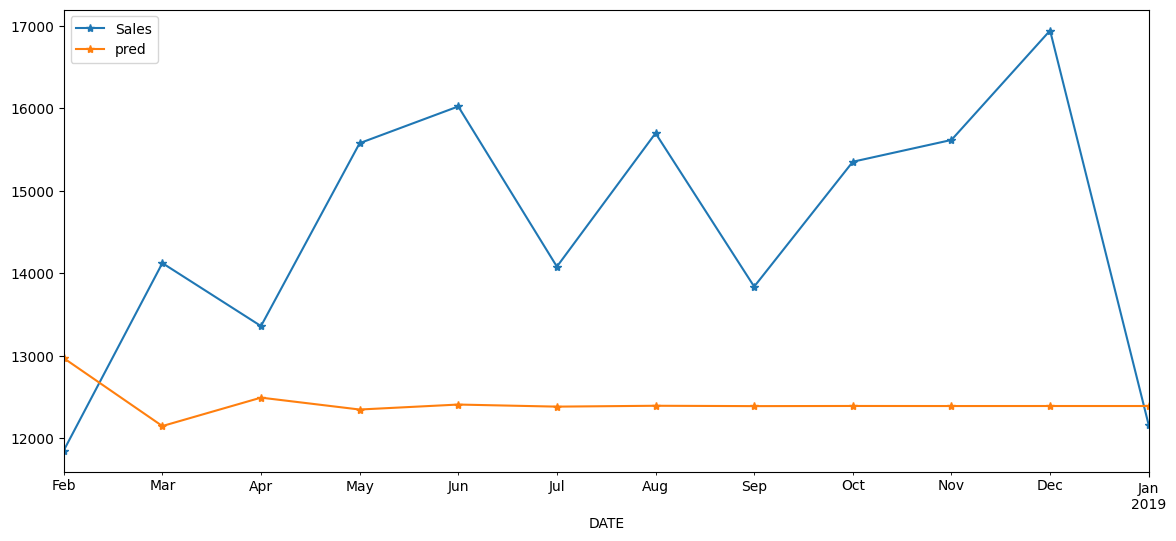

In [21]:
test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x.plot(style='-*')
performance(test_x['Sales'], test_x['pred'])

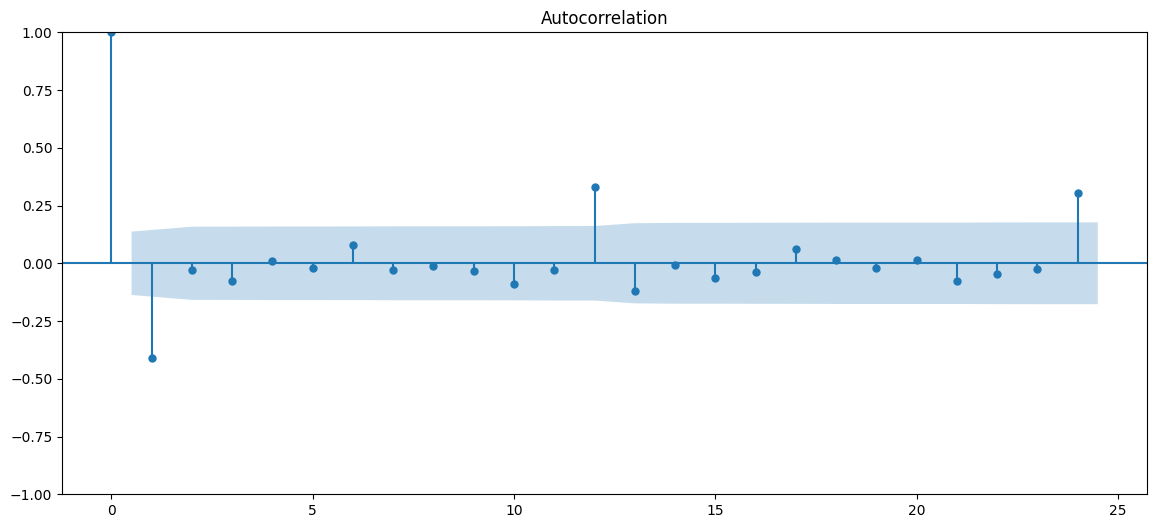

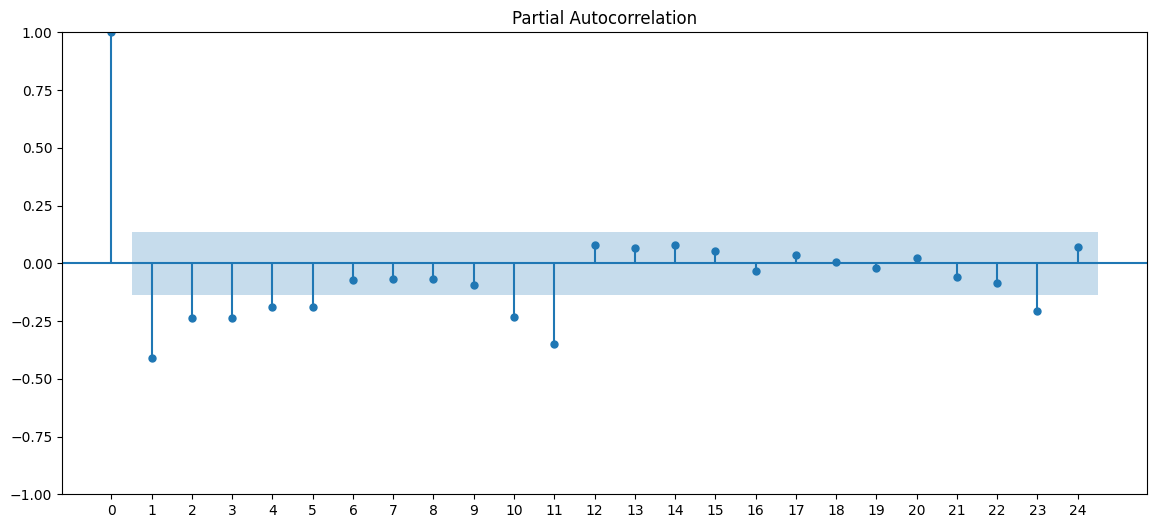

In [22]:
plot_acf(train_x_st.Sales);
plot_pacf(train_x_st.Sales);
plt.xticks(range(25))
plt.show()

> - **If the ACF plot gradually decreases, and PACF plot suddenly cuts of after lag k, then we can consider AR model with order p=k**
> - Here, there is also some seasonality which we did not remove, maybe there is also some quaterly seasonality, which is why the above rule does not give a clear guess -- Human judgement call needed here

c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\FPK1COB\AppData\Local\Temp\ipykernel_7468\3988825617.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]


MAE : 1591.085
RMSE : 1816.386
MAPE: 0.106


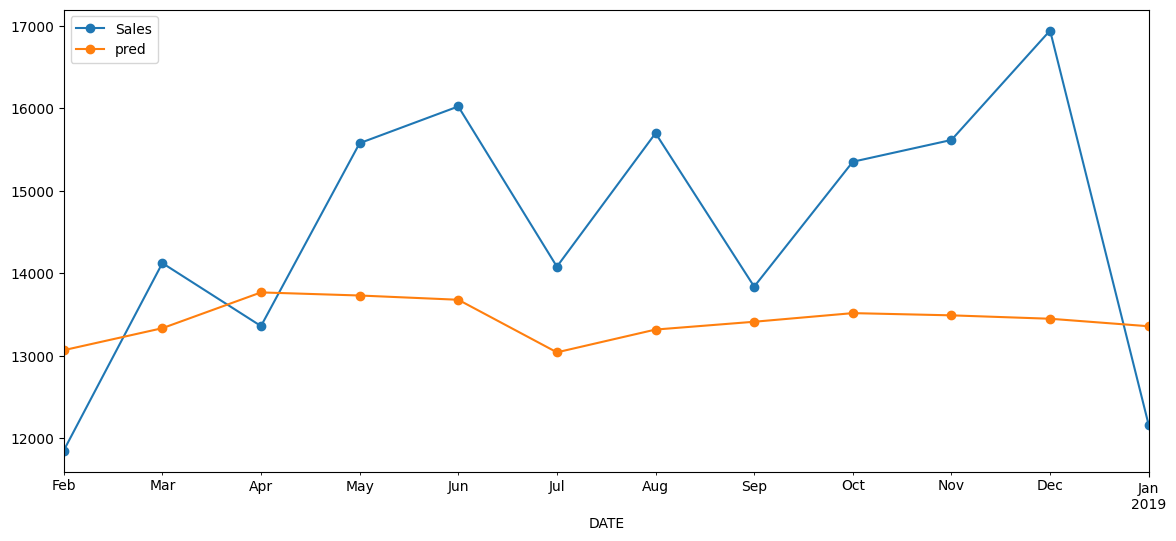

In [23]:
# from above pacf plot, p value can be 5
p = 5

# Train Model
model = SARIMAX(train_x_st.Sales, order=(p, 0, 0))
model = model.fit()

# Forecast
test_x['pred'] = model.forecast(steps=12)

# Integrating the trend back!
test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

# Plotting
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

**MA - Moving Average**

MAE : 1468.226
RMSE : 1728.739
MAPE: 0.099


c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\FPK1COB\AppData\Local\Temp\ipykernel_7468\1811606778.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]


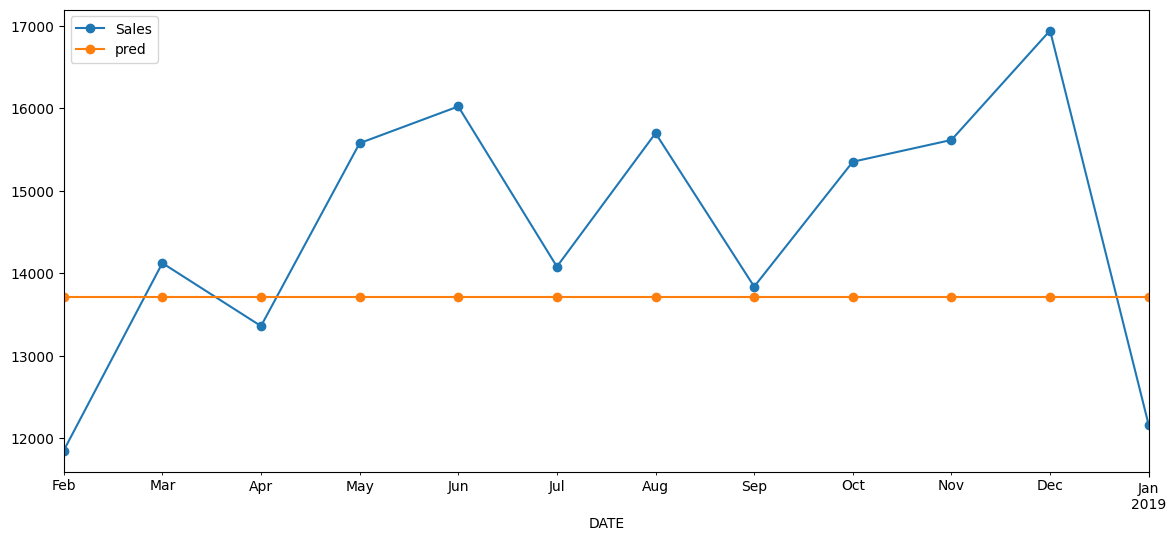

In [27]:
# order of MA
q = 1

# Train Model: order(p,d,q)
model = SARIMAX(train_x_st.Sales, order=(0, 0, 1))
model = model.fit(disp=False)

# forecast
test_x['pred'] = model.forecast(steps=12)

# Integrating the trend back!
test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

# Plotting
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

> In **MA**, **q** value can be determined by **ACF plot**  
> In **AR**, **p** value can be determined by **PACF plot**  
> However, in realtime scenarios it is difficult to find these values by plot  
> Therefore we use **Grid CV** to determine **best p and q** values

### ARMA

c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\FPK1COB\AppData\Local\Temp\ipykernel_7468\3551450814.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]


MAE : 1455.241
RMSE : 1690.468
MAPE: 0.097


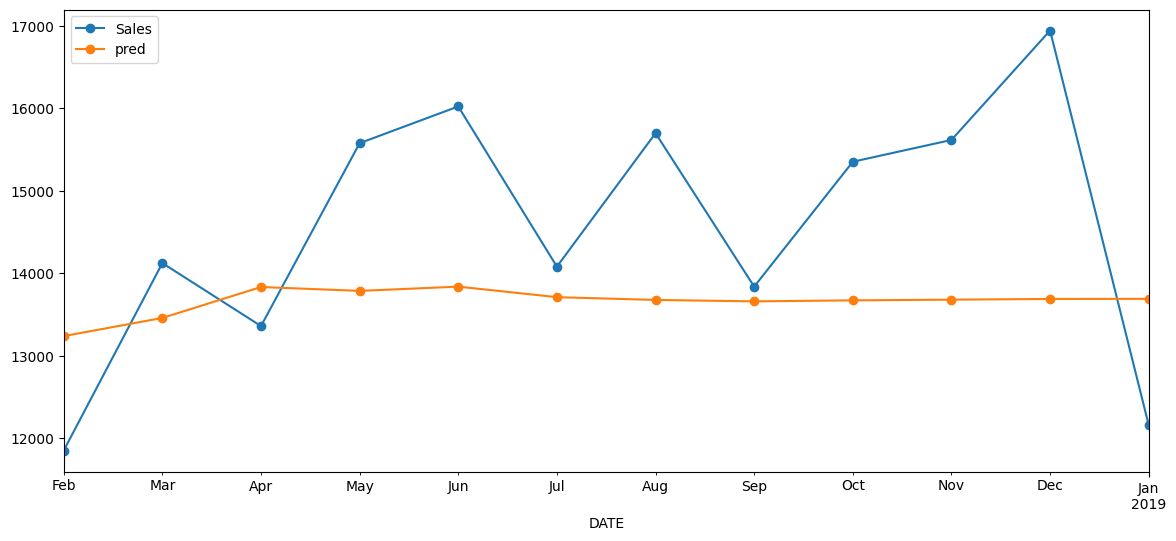

In [26]:
p = 5
q = 1

model = SARIMAX(train_x_st.Sales, order=(p, 0, q))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)

test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1]

test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### ARIMA

c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


MAE : 1458.399
RMSE : 1695.126
MAPE: 0.098


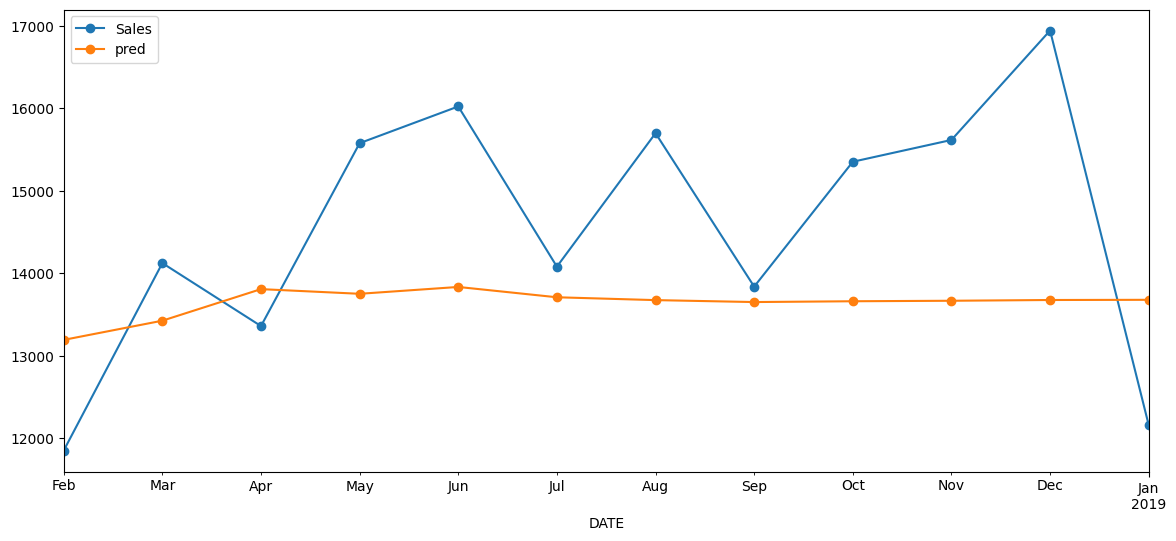

In [28]:
p = 5
q = 1
d = 1

model = SARIMAX(train_x.Sales, order=(p, d, q))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

### SARIMA

c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE : 735.822
RMSE : 808.604
MAPE: 0.05


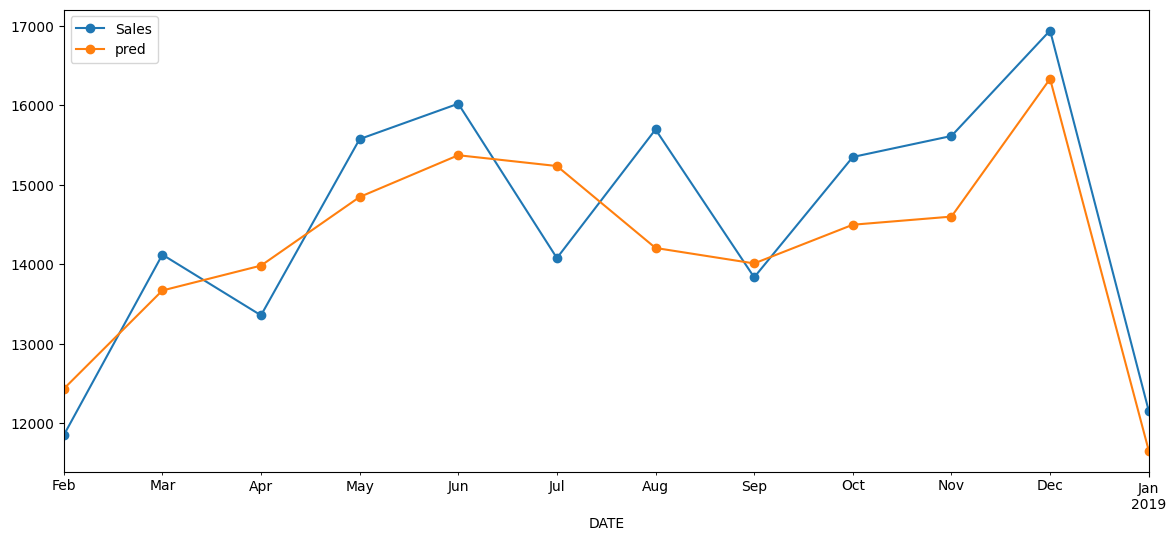

In [29]:
# Standard Parameters
p = 3
d = 1
q = 3

## Seasonal Parameters
P = 1
D = 1
Q = 1
S = 12

model = SARIMAX(train_x.Sales, order=(p, d, q), seasonal_order=(P,D,Q,S))
model = model.fit()
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])